# MCTS

In [79]:
import math
import numpy as np
EPS = 1e-8

class MCTS():
    """
    This class handles the MCTS tree.
    """

    def __init__(self, game, nnet, args):
        self.game = game
        self.nnet = nnet
        self.args = args
        self.Qsa = {}       # stores Q values for s,a (as defined in the paper)
        self.Nsa = {}       # stores #times edge s,a was visited
        self.Ns = {}        # stores #times board s was visited
        self.Ps = {}        # stores initial policy (returned by neural net)

        self.Es = {}        # stores game.getGameEnded ended for board s
        self.Vs = {}        # stores game.getValidMoves for board s
        
        self.val = [float('inf')]
        self.num_sim = [0]

    def getActionProb(self, state, temp=1):
        """
        This function performs numMCTSSims simulations of MCTS starting from
        canonicalBoard.
        Returns:
            probs: a policy vector where the probability of the ith action is
                   proportional to Nsa[(s,a)]**(1./temp)
        """
        for i in range(self.args.numMCTSSims):
            self.search(state, i)

        s = self.game.stringRepresentation(state)
        counts = [self.Nsa[(s,a)] if (s,a) in self.Nsa else 0 for a in range(self.game.getActionSize())]
        
        if temp==0:
            bestA = np.argmax(counts)
            probs = [0]*len(counts)
            probs[bestA]=1
            return probs

        counts = [x**(1./temp) for x in counts]
        counts_sum = float(sum(counts))
        probs = [x/counts_sum for x in counts]
        return probs


    def search(self, state, num_sim):
        """
        This function performs one iteration of MCTS. It is recursively called
        till a leaf node is found. The action chosen at each node is one that
        has the maximum upper confidence bound as in the paper.
        Once a leaf node is found, the neural network is called to return an
        initial policy P and a value v for the state. This value is propagated
        up the search path. In case the leaf node is a terminal state, the
        outcome is propagated up the search path. The values of Ns, Nsa, Qsa are
        updated.
        NOTE: the return values are the negative of the value of the current
        state. This is done since v is in [-1,1] and if v is the value of a
        state for the current player, then its value is -v for the other player.
        Returns:
            v: the negative of the value of the current canonicalBoard
        """

        s = self.game.stringRepresentation(state)
        
        if s not in self.Es:
            self.Es[s] = self.game.getGameEnded(state)
        if self.Es[s]!=0:
            # terminal node
            return 0

        if s not in self.Ps:
            # leaf node
            if self.nnet is not None:
                self.Ps[s], v = self.nnet.predict(state)
            else:
                self.Ps[s] = np.ones(self.game.getActionSize()) # random policy
                v = 0
            valids = self.game.getValidMoves(state)
            self.Ps[s] = self.Ps[s]*valids      # masking invalid moves
            sum_Ps_s = np.sum(self.Ps[s])
            if sum_Ps_s > 0:
                self.Ps[s] /= sum_Ps_s    # renormalize
            else:
                # if all valid moves were masked make all valid moves equally probable
                
                # NB! All valid moves may be masked if either your NNet architecture is insufficient or you've get overfitting or something else.
                # If you have got dozens or hundreds of these messages you should pay attention to your NNet and/or training process.   
                print("All valid moves were masked, do workaround.")
                self.Ps[s] = self.Ps[s] + valids
                self.Ps[s] /= np.sum(self.Ps[s])

            self.Vs[s] = valids
            self.Ns[s] = 0
            return v

        valids = self.Vs[s]
        cur_best = -float('inf')
        best_act = -1

        # pick the action with the highest upper confidence bound
        for a in range(self.game.getActionSize()):
            if valids[a]:
                if (s,a) in self.Qsa:
                    u = self.Qsa[(s,a)] + self.args.cpuct*self.Ps[s][a]*math.sqrt(self.Ns[s])/(1+self.Nsa[(s,a)])
                else:
                    u = self.args.cpuct*self.Ps[s][a]*math.sqrt(self.Ns[s] + EPS)     # Q = 0 ?

                if u > cur_best:
                    cur_best = u
                    best_act = a

        a = best_act
        next_s, reward = self.game.getNextState(state, a)

        v = self.search(next_s, num_sim) + reward

        if (s,a) in self.Qsa:
            self.Qsa[(s,a)] = (self.Nsa[(s,a)]*self.Qsa[(s,a)] + v)/(self.Nsa[(s,a)]+1)
            self.Nsa[(s,a)] += 1

        else:
            self.Qsa[(s,a)] = v
            self.Nsa[(s,a)] = 1
            
        if self.game.getActionSize() - self.val[-1] < v:
            self.val += [self.game.getActionSize() - v]
            self.num_sim += [num_sim]

        self.Ns[s] += 1
        return v

# TSPGame

In [80]:
from itertools import permutations 

class TSPGame():
    """
    This class specifies the base Game class. To define your own game, subclass
    this class and implement the functions below. This works when the game is
    two-player, adversarial and turn-based.
    Use 1 for player1 and -1 for player2.
    See othello/OthelloGame.py for an example implementation.
    """
    def __init__(self, args):
        self.num_node = args.num_node
        self.graph = np.random.rand(self.num_node, 2)

    def getStartState(self):
        """
        Returns:
            start_state: a representation of the graph
        """
        start_state = np.zeros([self.num_node, 2])
        start_state[0,0] = 1
        start_state[0,1] = 1
        return start_state

    def getActionSize(self):
        """
        Returns:
            self.num_node: number of all possible actions
        """
        return self.num_node

    def getNextState(self, state, action):
        """
        Input:
            state: current state
            action: action taken by current player
        Returns:
            next_state: graph after applying action
            reward: reward from action
        """
        next_state = state.copy()
        next_state[:, 1] = 0
        next_state[action, :] = 1
        prev_action = np.where(state[:, 1] == 1)[0][0]
        prev_node = self.graph[prev_action]
        cur_node = self.graph[action]
        reward = 1 - np.linalg.norm(cur_node - prev_node)
        if self.num_node == np.sum(next_state[:, 0]):
            reward += 1 - np.linalg.norm(cur_node - self.graph[0])
            
        return next_state, reward

    def getValidMoves(self, state):
        """
        Input:
            state: current state
        Returns:
            1 - state[:, 0]: a binary vector of length self.getActionSize(), 1 for
                            moves that are valid from the current board and player,
                            0 for invalid moves
        """
        return 1 - state[:, 0]

    def getGameEnded(self, state):
        """
        Input:
            state: current state
        Returns:
            r: 0 if game has not ended. 1 if it has
               
        """
        r = 0
        if self.num_node == np.sum(state[:, 0]):
            r = 1
        return r

    def stringRepresentation(self, state):
        """
        Input:
            state: current state
        Returns:
            s: string representation of state
        """
        s = ''
        for i in range(self.num_node):
            s += str(int(state[i, 0]))
        return s
    
    def optimal_sol(self):
        """
        Input:
            
        Returns:
            optimal_val: optimal solution for TSP
            optimal_path: optimal path for TSP
        """
        cur_reward = 0
        optimal_val = float('inf')
        optimal_path = []
        graph = self.graph

        nodes = np.arange(self.num_node)[1:]
        perms = permutations(nodes)
        
        for perm in list(perms):
            cur_reward = 0
            
            cur_reward += np.linalg.norm(graph[0] - graph[perm[0]])
            for i in range(len(perm) - 1):
                j = perm[i]
                k = perm[i+1]
                cur_reward += np.linalg.norm(graph[k] - graph[j])
            cur_reward += np.linalg.norm(graph[perm[-1]] - graph[0])
            
            if optimal_val > cur_reward:
                optimal_val = cur_reward
                optimal_path = perm
        
        return optimal_val, optimal_path

# Configuration

In [311]:
class dotdict(dict):
    def __getattr__(self, name):
        return self[name]

args = dotdict({
    # MCTS args
    'numMCTSSims': 100,          # Number of games moves for MCTS to simulate.
    'num_node': 5,                 # Number of nodes in the graph (game)
    
    # Train args
    'numIters': 5,
    'numEps': 10,              # Number of complete self-play games to simulate during a new iteration.
    'tempThreshold': 15,        #
    'updateThreshold': 0.6,     # During arena playoff, new neural net will be accepted if threshold or more of games are won.
    'maxlenOfQueue': 20000,    # Number of game examples to train the neural networks.
    'arenaCompare': 40,         # Number of games to play during arena play to determine if new net will be accepted.
    'cpuct': 1,
    'numItersForTrainExamplesHistory': 25,
    
    # NN args
    'lr': 0.001,
    'dropout': 0.3,
    'epochs': 10,
    'batch_size': 64,
    'cuda': False,
    'num_channels': 512,
    })

# Self Play

In [312]:
def play_game(args):
    game = TSPGame(args)
    mcts = MCTS(game, None, args)
    state = game.getStartState()
    mcts_reward = 0
    mcts_actions = []
    optimal_val, optimal_path = game.optimal_sol()
    
    while not game.getGameEnded(state):
        action = np.argmax(mcts.getActionProb(state))
        state, reward = game.getNextState(state, action)
        mcts_actions += [action]
        mcts_reward += reward
        
    print('Optimal Solution:', optimal_val)
    print('Optimal Action:', optimal_path)
    print('MCTS Reward:', game.getActionSize() - mcts_reward)
    print('MCTS Action:', mcts_actions)
    
    return mcts.val, mcts.num_sim, optimal_val

# Plot

In [313]:
val, num_sim, optimal_reward = play_game(args)
print(num_sim, val)

Optimal Solution: 2.595720927560539
Optimal Action: (1, 4, 3, 2)
MCTS Reward: 2.595720927560539
MCTS Action: [2, 3, 4, 1]
[0, 1, 2, 3, 4, 5, 6, 6, 13] [inf, 5.174470772061138, 4.341274525809415, 4.308739153424413, 3.902454824138017, 3.412126516590419, 3.3748506002401926, 2.716125126049607, 2.5957209275605395]


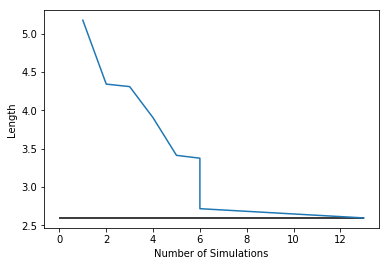

In [314]:
import matplotlib.pyplot as plt

plt.plot(np.array(num_sim[1:]), val[1:])
plt.xlabel("Number of Simulations")
plt.ylabel("Length")
plt.hlines(optimal_reward, 0, num_sim[-1])

# Part 1 (of Exercise)

In [315]:
results = {}
optimal_vals = []
for i in range(100):
    val, num_s, optimal_reward = play_game(args)
    results[i] = {tuple(num_s): val}
    optimal_vals += [optimal_reward]

Optimal Solution: 2.157601837923227
Optimal Action: (1, 4, 2, 3)
MCTS Reward: 2.1576018379232274
MCTS Action: [1, 4, 2, 3]
Optimal Solution: 2.6351760692998965
Optimal Action: (4, 1, 2, 3)
MCTS Reward: 2.664626608572924
MCTS Action: [2, 3, 1, 4]
Optimal Solution: 2.118583607240051
Optimal Action: (2, 1, 3, 4)
MCTS Reward: 2.4970218702141374
MCTS Action: [1, 2, 3, 4]
Optimal Solution: 2.4202630407896777
Optimal Action: (1, 3, 4, 2)
MCTS Reward: 2.4202630407896777
MCTS Action: [1, 3, 4, 2]
Optimal Solution: 2.5766814359244385
Optimal Action: (3, 1, 2, 4)
MCTS Reward: 2.5766814359244385
MCTS Action: [4, 2, 1, 3]
Optimal Solution: 1.4055124442157707
Optimal Action: (3, 4, 2, 1)
MCTS Reward: 1.4055124442157707
MCTS Action: [1, 2, 4, 3]
Optimal Solution: 2.1384156090476183
Optimal Action: (3, 2, 1, 4)
MCTS Reward: 2.1908176017089778
MCTS Action: [1, 2, 3, 4]
Optimal Solution: 1.9551110481558396
Optimal Action: (2, 1, 4, 3)
MCTS Reward: 2.018391734188263
MCTS Action: [1, 2, 4, 3]
Optimal Solu

Optimal Solution: 2.0999764336374387
Optimal Action: (2, 1, 4, 3)
MCTS Reward: 2.2206416330955108
MCTS Action: [1, 2, 4, 3]
Optimal Solution: 2.0030586921153275
Optimal Action: (4, 3, 2, 1)
MCTS Reward: 2.003058692115328
MCTS Action: [1, 2, 3, 4]
Optimal Solution: 1.6687944491865243
Optimal Action: (3, 2, 1, 4)
MCTS Reward: 1.7934099598734106
MCTS Action: [1, 2, 3, 4]
Optimal Solution: 1.9365520115335413
Optimal Action: (3, 1, 4, 2)
MCTS Reward: 2.5115196505327217
MCTS Action: [1, 2, 4, 3]
Optimal Solution: 2.049709653226701
Optimal Action: (2, 3, 1, 4)
MCTS Reward: 2.180801372221283
MCTS Action: [1, 4, 3, 2]
Optimal Solution: 2.7882859696310622
Optimal Action: (1, 3, 4, 2)
MCTS Reward: 3.245887467399305
MCTS Action: [1, 2, 4, 3]
Optimal Solution: 2.4464313922356777
Optimal Action: (4, 3, 1, 2)
MCTS Reward: 2.7824325029608583
MCTS Action: [1, 3, 2, 4]
Optimal Solution: 1.923252956234121
Optimal Action: (4, 3, 1, 2)
MCTS Reward: 2.1979319833832998
MCTS Action: [1, 3, 4, 2]
Optimal Solut

In [316]:
# import json
# j = json.dumps(results)
# f = open("dict.json","w")
# f.write(j)
# f.close()

In [317]:
# f = open("dict.txt","w")
# f.write( str(results) )
# f.close()

In [318]:
# import pickle
# f = open("dict.pkl","wb")
# pickle.dump(results,f)
# f.close()

In [378]:
from collections import deque
import time, os, sys
from pickle import Pickler, Unpickler
from random import shuffle


class Coach():
    """
    This class executes the self-play + learning. It uses the functions defined
    in Game and NeuralNet. args are specified in main.py.
    """
    def __init__(self, game, nnet, args):
        self.game = game
        self.nnet = nnet
#         self.pnet = self.nnet.__class__(self.game)  # the competitor network
        self.args = args
        self.mcts = MCTS(self.game, self.nnet, self.args)
        self.trainExamplesHistory = []    # history of examples from args.numItersForTrainExamplesHistory latest iterations
        self.skipFirstSelfPlay = False    # can be overriden in loadTrainExamples()

    def executeEpisode(self):
        """
        This function executes one episode of self-play, starting with player 1.
        As the game is played, each turn is added as a training example to
        trainExamples. The game is played till the game ends. After the game
        ends, the outcome of the game is used to assign values to each example
        in trainExamples.

        It uses a temp=1 if episodeStep < tempThreshold, and thereafter
        uses temp=0.

        Returns:
            trainExamples: a list of examples of the form (canonicalBoard,pi,v)
                           pi is the MCTS informed policy vector, v is +1 if
                           the player eventually won the game, else -1.
        """
        trainExamples = []
        board = self.game.getStartState()
#         self.curPlayer = 1
        episodeStep = 0

        while True:
            episodeStep += 1
            temp = int(episodeStep < self.args.tempThreshold)

            pi = self.mcts.getActionProb(board, temp=temp)

            action = np.random.choice(len(pi), p=pi)
            next_board, reward = self.game.getNextState(board, action)
            trainExamples.append([board, pi, reward])

            r = self.game.getGameEnded(next_board)
            
            if r!=0:
                return [tuple(x) for x in trainExamples]
            
            board = next_board

    def learn(self):
        """
        Performs numIters iterations with numEps episodes of self-play in each
        iteration. After every iteration, it retrains neural network with
        examples in trainExamples (which has a maximum length of maxlenofQueue).
        It then pits the new neural network against the old one and accepts it
        only if it wins >= updateThreshold fraction of games.
        """
        for i in range(1, self.args.numIters+1):
            # bookkeeping
            print('------ITER ' + str(i) + '------')
            # examples of the iteration
            if not self.skipFirstSelfPlay or i>1:
                iterationTrainExamples = deque([], maxlen=self.args.maxlenOfQueue)

                for eps in range(self.args.numEps):
                    self.mcts = MCTS(self.game, self.nnet, self.args)   # reset search tree
                    iterationTrainExamples += self.executeEpisode()

                self.trainExamplesHistory.append(iterationTrainExamples)
                
            if len(self.trainExamplesHistory) > self.args.numItersForTrainExamplesHistory:
                print("len(trainExamplesHistory) =", len(self.trainExamplesHistory), " => remove the oldest trainExamples")
                self.trainExamplesHistory.pop(0)

            # shuffle examples before training
            trainExamples = []
            for e in self.trainExamplesHistory:
                trainExamples.extend(e)
            shuffle(trainExamples)
            
            # train
            self.nnet.train(trainExamples)


In [379]:
import sys
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [380]:
class NNet():
    def __init__(self, game, args):
        self.b = game.num_node
        self.action_size = game.getActionSize()
        
        self.create_net(game)

    def train(self, examples):
        """
        examples: list of examples, each example is of form (board, pi, v)
        """
        print("Training...")
        input_boards, target_pis, target_vs = list(zip(*examples))
        input_boards = np.asarray(input_boards)
        target_pis = np.asarray(target_pis)
        target_vs = np.asarray(target_vs)
        self.model.fit(x = input_boards, y = [target_pis, target_vs], batch_size = args.batch_size, epochs = args.epochs)

    def predict(self, board):
        """
        board: np array with board
        """
        # preparing input
        board = board[np.newaxis, :, :]

        # run
        pi, v = self.model.predict(board)

        #print('PREDICTION TIME TAKEN : {0:03f}'.format(time.time()-start))
        return pi[0], v[0]
    
    def create_net(self, game):
        # Neural Net
        self.input_boards = Input(shape=game.getStartState().shape)    # s: batch_size x board_x x board_y

        x_image = Reshape((args['num_node'], 2, 1))(self.input_boards)                # batch_size  x board_x x board_y x 1
        h_conv1 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 2, padding='same')(x_image)))         # batch_size  x board_x x board_y x num_channels
        h_conv2 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 2, padding='same')(h_conv1)))         # batch_size  x board_x x board_y x num_channels
        h_conv3 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 2, padding='same')(h_conv2)))        # batch_size  x (board_x) x (board_y) x num_channels
        h_conv4 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 2, padding='valid')(h_conv3)))        # batch_size  x (board_x-2) x (board_y-2) x num_channels
        h_conv4_flat = Flatten()(h_conv4)       
        s_fc1 = Dropout(args.dropout)(Activation('relu')(BatchNormalization(axis=1)(Dense(1024)(h_conv4_flat))))  # batch_size x 1024
        s_fc2 = Dropout(args.dropout)(Activation('relu')(BatchNormalization(axis=1)(Dense(512)(s_fc1))))          # batch_size x 1024
        self.pi = Dense(self.action_size, activation='softmax', name='pi')(s_fc2)   # batch_size x self.action_size
        self.v = Dense(1, activation='tanh', name='v')(s_fc2)                    # batch_size x 1

        self.model = Model(inputs=self.input_boards, outputs=[self.pi, self.v])
        self.model.compile(loss=['categorical_crossentropy','mean_squared_error'], optimizer=Adam(args.lr))

In [381]:
t = TSPGame(args)
n = NNet(t, args)
c = Coach(t, n, args)

In [382]:
c.learn()

------ITER 1------
Training...
Epoch 1/10
40/40 [==============================] - 6s 149ms/step - loss: 3.0192 - pi_loss: 1.7182 - v_loss: 1.3010
Epoch 2/10
40/40 [==============================] - 0s 8ms/step - loss: 1.2762 - pi_loss: 0.4056 - v_loss: 0.8707
Epoch 3/10
40/40 [==============================] - 0s 8ms/step - loss: 1.5360 - pi_loss: 0.3624 - v_loss: 1.1736
Epoch 4/10
40/40 [==============================] - 0s 8ms/step - loss: 0.9002 - pi_loss: 0.3414 - v_loss: 0.5587
Epoch 5/10
40/40 [==============================] - 0s 8ms/step - loss: 0.8648 - pi_loss: 0.3107 - v_loss: 0.5541
Epoch 6/10
40/40 [==============================] - 0s 8ms/step - loss: 0.8774 - pi_loss: 0.3144 - v_loss: 0.5630
Epoch 7/10
40/40 [==============================] - 0s 8ms/step - loss: 0.8357 - pi_loss: 0.2839 - v_loss: 0.5518
Epoch 8/10
40/40 [==============================] - 0s 8ms/step - loss: 0.8434 - pi_loss: 0.2894 - v_loss: 0.5540
Epoch 9/10
40/40 [==============================] - 0s 

In [399]:
## Code to run the trained neural net with mcts

mcts = MCTS(t, n, args)
state = t.getStartState()
mcts_reward = 0
mcts_actions = []
optimal_val, optimal_path = t.optimal_sol()

while not t.getGameEnded(state):
    p = mcts.getActionProb(state)
    print(p)
    action = np.argmax(p)
    state, reward = t.getNextState(state, action)
    mcts_actions += [action]
    mcts_reward += reward

print('Optimal Solution:', optimal_val)
print('Optimal Action:', optimal_path)
print('MCTS Reward:', t.getActionSize() - mcts_reward)
print('MCTS Action:', mcts_actions)

mcts.val, mcts.num_sim, optimal_val

[0.0, 0.0, 0.0, 1.0, 0.0]
[0.0, 0.12626262626262627, 0.20707070707070707, 0.0, 0.6666666666666666]
[0.0, 0.0735930735930736, 0.9264069264069265, 0.0, 0.0]
[0.0, 1.0, 0.0, 0.0, 0.0]
Optimal Solution: 2.7110423169141296
Optimal Action: (1, 2, 4, 3)
MCTS Reward: 2.7110423169141296
MCTS Action: [3, 4, 2, 1]


([inf,
  array([3.8642402], dtype=float32),
  array([3.8425543], dtype=float32),
  array([3.4731977], dtype=float32),
  array([3.3190312], dtype=float32),
  array([2.9496746], dtype=float32),
  2.891461675370669,
  array([2.5841117], dtype=float32)],
 [0, 1, 2, 2, 3, 3, 44, 66],
 2.7110423169141296)

In [397]:
c.args['numMCTSSims'] = 100

In [ ]:
#### GNN will be implemented next ####

# GNN

In [0]:
import dgl

def build_karate_club_graph():
    g = dgl.DGLGraph()
    # add 10 nodes into the graph; nodes are labeled from 0~9
    g.add_nodes(10)
    # all edges as a list of tuples
    edge_list = [(0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8), (0,9),
                 (1,0), (1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8), (1,9),
                 (2,1), (2,0), (2,3), (2,4), (2,5), (2,6), (2,7), (2,8), (2,9),
                 (3,1), (3,2), (3,0), (3,4), (3,5), (3,6), (3,7), (3,8), (3,9),
                 (4,1), (4,2), (4,3), (4,0), (4,5), (4,6), (4,7), (4,8), (4,9),
                 (5,1), (5,2), (5,3), (5,4), (5,0), (5,6), (5,7), (5,8), (5,9),
                 (6,1), (6,2), (6,3), (6,4), (6,5), (6,0), (6,7), (6,8), (6,9),
                 (7,1), (7,2), (7,3), (7,4), (7,5), (7,6), (7,0), (7,8), (7,9),
                 (8,1), (8,2), (8,3), (8,4), (8,5), (8,6), (8,7), (8,0), (8,9),
                 (9,1), (9,2), (9,3), (9,4), (9,5), (9,6), (9,7), (9,8), (9,0)]
    # add edges two lists of nodes: src and dst
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    # edges are directional in DGL; make them bi-directional
    # g.add_edges(dst, src)

    return g

In [47]:
G = build_karate_club_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 10 nodes.
We have 90 edges.


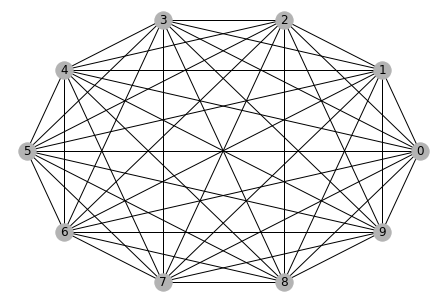

In [48]:
import networkx as nx
# Since the actual graph is undirected, we convert it for visualization purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [0]:
import torch

G.ndata['feat'] = torch.eye(10)

In [50]:
# print out node 2's input feature
print(G.nodes[2].data['feat'])

# print out node 7 and 8's input features
print(G.nodes[[7, 8]].data['feat'])

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])


In [0]:
import torch.nn as nn
import torch.nn.functional as F

# Define the message and reduce function
# NOTE: We ignore the GCN's normalization constant c_ij for this tutorial.
def gcn_message(edges):
    # The argument is a batch of edges.
    # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    # The argument is a batch of nodes.
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

In [0]:
# Define a 2-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h
# The first layer transforms input features of size of 10 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two outputs.
net = GCN(10, 5, 2)

In [0]:
inputs = torch.eye(10)
labeled_nodes = torch.tensor([0, 9])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

In [54]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(30):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.6817
Epoch 1 | Loss: 0.6919
Epoch 2 | Loss: 0.6777
Epoch 3 | Loss: 0.6786
Epoch 4 | Loss: 0.6788
Epoch 5 | Loss: 0.6739
Epoch 6 | Loss: 0.6671
Epoch 7 | Loss: 0.6621
Epoch 8 | Loss: 0.6587
Epoch 9 | Loss: 0.6555
Epoch 10 | Loss: 0.6506
Epoch 11 | Loss: 0.6455
Epoch 12 | Loss: 0.6422
Epoch 13 | Loss: 0.6370
Epoch 14 | Loss: 0.6300
Epoch 15 | Loss: 0.6253
Epoch 16 | Loss: 0.6190
Epoch 17 | Loss: 0.6111
Epoch 18 | Loss: 0.6052
Epoch 19 | Loss: 0.5966
Epoch 20 | Loss: 0.5886
Epoch 21 | Loss: 0.5804
Epoch 22 | Loss: 0.5705
Epoch 23 | Loss: 0.5620
Epoch 24 | Loss: 0.5508
Epoch 25 | Loss: 0.5413
Epoch 26 | Loss: 0.5292
Epoch 27 | Loss: 0.5188
Epoch 28 | Loss: 0.5058
Epoch 29 | Loss: 0.4943
